# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn
main_path = '/mnt/raid/ni/agnessa/RSA/'


# Define the function to create filenames

In [2]:
def getFileName(n_samples,name,model_name,layer_name):
    return name \
        + "_{}_".format(n_samples) \
        + "_{}_".format(model_name) \
        + "_{}".format(layer_name)  \
        + ".npy"       

# Average correlation of a subset of layers for two networks (same model, different training tasks) - use the whole matrix (not just upper triangular)

In [3]:
def avg_correlation_cross_task(model_name,trained_on_1,trained_on_2,tested_on,min_layer_idx,max_layer_idx):
    layer_name = 'all'
    
    #define number of samples depending on the testing dataset
    if tested_on == 'ImageNet' or tested_on == '':
        n_samples = 10000
    elif tested_on == 'Places365':
        n_samples = 10220
        
    #load the models
    model_rdm_1_filename = os.path.join(main_path,trained_on_1,'','Model_RDM', \
                                      getFileName(n_samples,'Model_RDM',model_name,layer_name))
    model_name_2 = model_name+'_'+model_name
    model_rdm_2_filename = os.path.join(main_path,trained_on_2,tested_on,'Model_RDM', \
                                      getFileName(n_samples,'Model_RDM_cross_task',model_name_2,layer_name))  
    model_rdm_1 = np.load(model_rdm_1_filename)
    model_rdm_2 = np.load(model_rdm_2_filename)
    
    #select only the desired layers
    selected_model_rdm_1 = model_rdm_1[min_layer_idx:max_layer_idx+1,min_layer_idx:max_layer_idx+1]#plus one makes sure that the last layer is included
    selected_model_rdm_2 = model_rdm_2[min_layer_idx:max_layer_idx+1,min_layer_idx:max_layer_idx+1]
   
    #get the correlation
    avg_correlation_1 = 1-np.mean(selected_model_rdm_1)
    avg_correlation_2 = 1-np.mean(selected_model_rdm_2)
    return avg_correlation_1, avg_correlation_2

In [4]:
r50e1,r50e2 = (avg_correlation_cross_task('resnet50','Objects','Scenes','ImageNet',0,6))
r50l1,r50l2 = (avg_correlation_cross_task('resnet50','Objects','Scenes','ImageNet',7,15))
ane1,ane2 = (avg_correlation_cross_task('alexnet','Objects','Scenes','ImageNet',0,8))
anl1,anl2 = (avg_correlation_cross_task('alexnet','Objects','Scenes','ImageNet',9,20))

print(r50e1,r50e2)
print(r50l1,r50l2)
print(ane1,ane2)
print(anl1,anl2)

0.8302358924957872 0.7865401977739996
0.7438252951049977 0.5654349999732273
0.6144572932756704 0.5630306083774066
0.8024377576838364 0.5301913994149587


# Plot the correlations (bar plot)

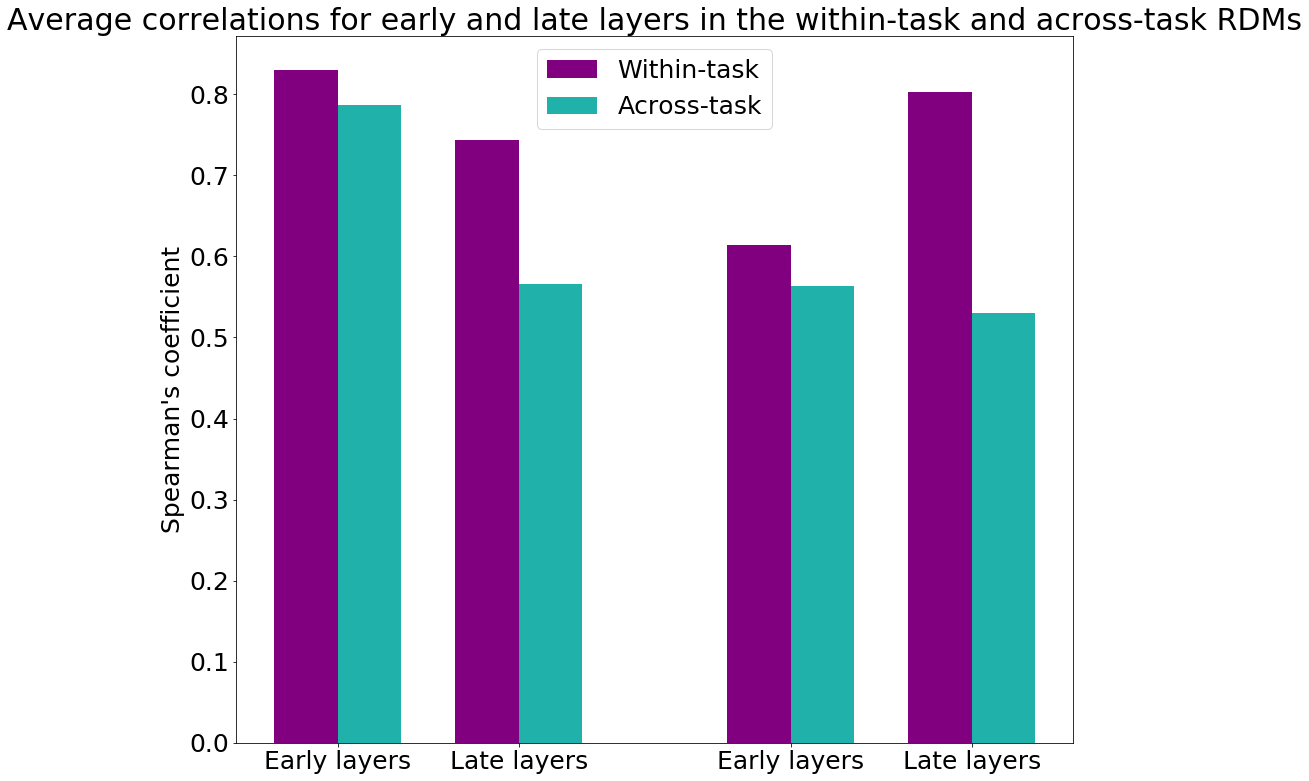

In [49]:
f, ax = plt.subplots(figsize=(15,13))

within_task_rn = [r50e1,r50l1]
across_tasks_rn = [r50e2,r50l2]
within_task_an = [ane1,anl1]
across_tasks_an = [ane2,anl2]

N = 2
ind = np.arange(N) 
width = 0.35       

#resnet-50
w_rn = plt.bar(ind, within_task_rn, width, label='Within task', color='purple')
a_rn = plt.bar(ind + width, across_tasks_rn, width, label='Across tasks', color='lightseagreen')

#alexnet50
ind2 = np.arange(N)+2.5
w_an = plt.bar(ind2, within_task_an, width, label='Within task', color='purple')
w_an = plt.bar(ind2 + width, across_tasks_an, width, label='Across tasks', color='lightseagreen')

#plotting parameters
plt.title('Average correlations for early and late layers in the within-task and across-task RDMs',fontsize=30)
plt.ylabel('Spearman\'s coefficient',fontsize=25)
ind3 = np.concatenate([ind,ind2])
plt.xticks(ind3 + width / 2, ('Early layers', 'Late layers','Early layers', 'Late layers'),fontsize=25)
plt.yticks(fontsize=25)
plt.legend([w_rn,a_rn],['Within-task', 'Across-task'],loc='best', fontsize=25)

plt.show()

In [ ]:
def autolabel(bar_pairs, model_names):
    """Attach a text label below each pair of bars (in the middle), displaying the model name."""
    for bp in bar_pairs:
        model_name_label = model_names[bp]
        ax.annotate('{}'.format(model_name_label),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(b,model_names)
model_names  = ['ResNet-50','AlexNet']
